### Problem Statement
[insert]


### Import Data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# https://data.ny.gov/Transportation/Turnstile-Usage-Data-2016/ekwu-khcy
# https://data.ny.gov/api/views/ekwu-khcy/rows.csv?accessType=DOWNLOAD
data = pd.read_csv('Turnstile_Usage_Data__2016.csv')
data = pd.DataFrame(data) # change to pandas dataframe
# parse spaces from columns; to use better approach when 
data=data.rename(columns = {'Exits                                                     ':'Exits'})
# Do we need to convert Date column to datetime?
# data['Date'] = data['Date'].to_datetime()
# data['Date'] = data['Date'].dt.date


/Users/brianmcmahon/anaconda3/envs/tensorflow1.4/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# data['Date'] = data['Date'].astype('datetime64') # convert data column to date type
print(type(data['Date']))
# remove first few columns, deemed irrelevant
data = data.iloc[:,3:]
data.head()

<class 'pandas.core.series.Series'>


,Station,Line Name,Division,Date,Time,Description,Entries,Exits
0,59 ST,NQR456,BMT,03/04/2016,23:00:00,REGULAR,5572864,1881239
1,59 ST,NQR456,BMT,03/04/2016,19:00:00,REGULAR,5572521,1881206
2,59 ST,NQR456,BMT,03/04/2016,15:00:00,REGULAR,5571587,1881113
3,59 ST,NQR456,BMT,03/04/2016,11:00:00,REGULAR,5571313,1881031
4,59 ST,NQR456,BMT,03/04/2016,08:10:05,REGULAR,5571173,1880736


### Process Data

In [ ]:
# Groupby Station, Day


In [4]:
# Data presented as cumulative; add columns to track the increment
# Add Traffic_Tot column as sum of Entry and Exit to represent activity
data['Entry_Inc'] = abs(data.Entries.diff())
data['Exits_Inc'] = abs(data.Exits.diff())
data['Traffic_Tot'] = np.add(data.Entry_Inc, data.Exits_Inc)
data.head()

,Station,Line Name,Division,Date,Time,Description,Entries,Exits,Entry_Inc,Exits_Inc,Traffic_Tot
0,59 ST,NQR456,BMT,03/04/2016,23:00:00,REGULAR,5572864,1881239,NaN,NaN,NaN
1,59 ST,NQR456,BMT,03/04/2016,19:00:00,REGULAR,5572521,1881206,343.0,33.0,376.0
2,59 ST,NQR456,BMT,03/04/2016,15:00:00,REGULAR,5571587,1881113,934.0,93.0,1027.0
3,59 ST,NQR456,BMT,03/04/2016,11:00:00,REGULAR,5571313,1881031,274.0,82.0,356.0
4,59 ST,NQR456,BMT,03/04/2016,08:10:05,REGULAR,5571173,1880736,140.0,295.0,435.0


In [5]:
# filter outliers above specified quantile
quant_filt = 0.99
q = data["Entry_Inc"].quantile(quant_filt)
data = data[data["Entry_Inc"] < q]

r = data["Exits_Inc"].quantile(quant_filt)
data = data[data["Exits_Inc"] < r]

s = data["Traffic_Tot"].quantile(quant_filt)
data = data[data["Traffic_Tot"] < s]

data = data.dropna() # apparently no issues with NaN cells; running as best practice

data.head()

,Station,Line Name,Division,Date,Time,Description,Entries,Exits,Entry_Inc,Exits_Inc,Traffic_Tot
1,59 ST,NQR456,BMT,03/04/2016,19:00:00,REGULAR,5572521,1881206,343.0,33.0,376.0
2,59 ST,NQR456,BMT,03/04/2016,15:00:00,REGULAR,5571587,1881113,934.0,93.0,1027.0
3,59 ST,NQR456,BMT,03/04/2016,11:00:00,REGULAR,5571313,1881031,274.0,82.0,356.0
4,59 ST,NQR456,BMT,03/04/2016,08:10:05,REGULAR,5571173,1880736,140.0,295.0,435.0
5,59 ST,NQR456,BMT,03/04/2016,07:00:00,REGULAR,5571136,1880657,37.0,79.0,116.0


### Sort Data
Data is sorted by Station.

In [6]:
data_stndatetime = data.groupby([ "Station", "Date",'Time']).sum() # sort by station, date and time
data_stndatetime.head()

Entries       Exits  Entry_Inc  Exits_Inc  \
Station Date       Time                                                     
1 AV    01/02/2016 03:00:00  1407788395  1469357462      319.0      525.0   
                   07:00:00  1407788714  1469357987     1607.0     1841.0   
                   11:00:00  1407790321  1469359828     3904.0     3802.0   
                   15:00:00  1407794225  1469363630     4463.0     5779.0   
                   19:00:00  1407798688  1469369409     4132.0     4991.0   

                             Traffic_Tot  
Station Date       Time                   
1 AV    01/02/2016 03:00:00        844.0  
                   07:00:00       3448.0  
                   11:00:00       7706.0  
                   15:00:00      10242.0  
                   19:00:00       9123.0

In [7]:
data_stn = data.groupby([ "Station"]).sum() # sort by station
data_stn = pd.DataFrame(data_stn) # convert to panda dataframe
data_stn['Station_ID'] = data_stn.index # Make Station_ID a non-index column
data_stn = data_stn.sort_values(['Traffic_Tot'], ascending=[False]) # Sort stations by traffic
data_stn['Idx'] = np.arange(data_stn.shape[0]) # add enumerated column
data_stn = data_stn.set_index('Idx') # assign enumerated column as index column
data_stn.head()

,Entries,Exits,Entry_Inc,Exits_Inc,Traffic_Tot,Station_ID
Idx,,,,,,
0,6688304157199,3630511989854,43389327.0,35722750.0,79112077.0,34 ST-PENN STA
1,12665339112269,11696989712585,31416768.0,23977529.0,55394297.0,23 ST
2,5847951627430,6098512500597,27860423.0,24614007.0,52474430.0,34 ST-HERALD SQ
3,11539236191101,9178257398340,25838571.0,23245722.0,49084293.0,TIMES SQ-42 ST
4,7901555330882,2052315189136,25151182.0,22764739.0,47915921.0,GRD CNTRL-42 ST


## Prep Data for Charting

In [8]:
# demographic data: NYC census
# map of startups in NYC
# calendar of tech events
# unicorn 

import seaborn as sns
sns.set_style("whitegrid")


In [11]:
data_stn = data_stn.iloc[:20,:] # limit to 20 most active stations

data_stn.head()


,Entries,Exits,Entry_Inc,Exits_Inc,Traffic_Tot,Station_ID
Idx,,,,,,
0,6688304157199,3630511989854,43389327.0,35722750.0,79112077.0,34 ST-PENN STA
1,12665339112269,11696989712585,31416768.0,23977529.0,55394297.0,23 ST
2,5847951627430,6098512500597,27860423.0,24614007.0,52474430.0,34 ST-HERALD SQ
3,11539236191101,9178257398340,25838571.0,23245722.0,49084293.0,TIMES SQ-42 ST
4,7901555330882,2052315189136,25151182.0,22764739.0,47915921.0,GRD CNTRL-42 ST


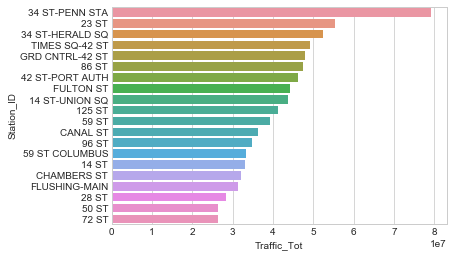

In [13]:
# verify results: check http://web.mta.info/nyct/facts/ffsubway.htm
ax = sns.barplot(x="Traffic_Tot", y='Station_ID', data=data_stn)
# gut feeling is that 23rd St is not a top station.  If more time, would
# further analyze 23rd Street for outliers.


In [14]:
# PROBLEM STATEMENT
# Optimize utilization of street teams by using data science by utilizing MTA 
# and [Demographic] data

# PRESENTATION
# Executive Summary / Scenario
# MTA findings
# Demographic findings
# Combined MTA/Demo Analysis
# Conclusion
# Q&A

# TODO:
# Clean up JN
# day/hour analyses
# combine demographic data
# Map which includes demographic data (ie income) and station activity (by size of dot)
# Analyze top stations by time period (season, month, week, day, hour)
# add lat/long
# vet data better / graph 

# Tomorrow morning
# Finished pres, practice

### Top Station Activity: Penn Station 34th Street

In [24]:
data_Penn = data[data['Station'] == '34 ST-PENN STA']
# data_Penn.head()
np.max(data_Penn['Traffic_Tot'])


1816.0

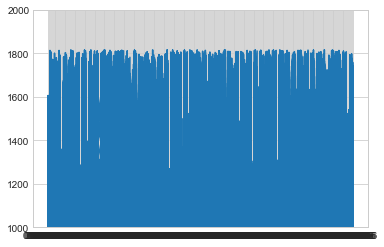

In [16]:
y = pd.Series(data_Penn['Traffic_Tot'])
x = pd.Series(data_Penn['Date'])

plt.plot(x,y)
axes = plt.gca()
axes.set_ylim([1000,2000])
plt.show()

### Top Station Activity: 23rd St

In [25]:
data_23ST = data[data['Station'] == '23 ST']
# data_23ST.head()
np.max(data_23ST['Traffic_Tot'])


1816.0

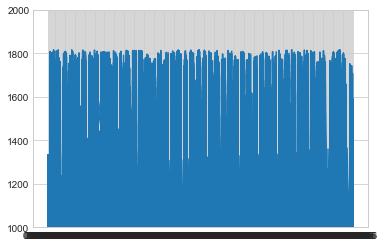

In [18]:
y = pd.Series(data_23ST['Traffic_Tot'])
x = pd.Series(data_23ST['Date'])

plt.plot(x,y)
axes = plt.gca()
axes.set_ylim([1000,2000])
plt.show()

### Top Station Activity: 72nd St

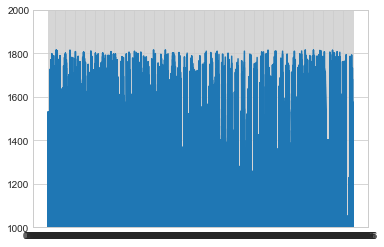

In [19]:
data_72ST = data[data['Station'] == '72 ST']
y = pd.Series(data_72ST['Traffic_Tot'])
x = pd.Series(data_72ST['Date'])

plt.plot(x,y)
axes = plt.gca()
axes.set_ylim([1000,2000])
plt.show()

In [21]:
data = pd.DataFrame(data)
data['Date'] = pd.to_datetime(data['Date'])
type(data['Date'])

KeyboardInterrupt: 